In [1]:
import mxnet as mx
from mxnet import gluon, autograd ,nd, lr_scheduler
from mxnet.gluon import nn, utils
import mxnet.ndarray as F
import numpy as np
import os, sys
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
class Decoder(nn.HybridBlock):
    def __init__(self,param,**kwargs):
        super(Decoder,self).__init__(**kwargs)
        self.num_channel = param['num_channel']
        self.b_size = param['batch_size']
        self.scale_size = param['scale_size']
        
        with self.name_scope():
            self.l0 = nn.Dense(8*8*self.num_channel)
            self.l1 = nn.Conv2D(self.num_channel,3,1,1)
            self.l2 = nn.Conv2D(self.num_channel,3,1,1)
            #self.up1 = F.UpSampling(scale=2,sample_type='nearest')
            self.l3 = nn.Conv2D(self.num_channel,3,1,1)
            self.l4 = nn.Conv2D(self.num_channel,3,1,1)
            #self.up2 = F.UpSampling(scale=2,sample_type='nearest')
            self.l5 = nn.Conv2D(self.num_channel,3,1,1)
            self.l6 = nn.Conv2D(self.num_channel,3,1,1)
            #self.up3 = F.UpSampling(scale=2,sample_type='nearest')
            self.l7 = nn.Conv2D(self.num_channel,3,1,1)
            self.l8 = nn.Conv2D(self.num_channel,3,1,1)
            self.l9 = nn.Conv2D(3,3,1,1)
        
    def forward(self,x):
        x = self.l0(x)
        x = x.reshape((-1,self.num_channel,8,8)) ## reshape
        
        x = F.LeakyReLU(data=self.l1(x),act_type='elu')
        x = F.LeakyReLU(data=self.l2(x),act_type='elu')
        x = F.UpSampling(x,scale=2,sample_type='nearest')
        
        x = F.LeakyReLU(data=self.l3(x),act_type='elu')
        x = F.LeakyReLU(data=self.l4(x),act_type='elu')
        x = F.UpSampling(x,scale=2,sample_type='nearest')
        
        x = F.LeakyReLU(data=self.l5(x),act_type='elu')
        x = F.LeakyReLU(data=self.l6(x),act_type='elu')
        #x = F.UpSampling(x,scale=2,sample_type='nearest')
        
        x = F.LeakyReLU(data=self.l7(x),act_type='elu')
        x = F.LeakyReLU(data=self.l8(x),act_type='elu')
        x = F.LeakyReLU(data=self.l9(x),act_type='elu')
        
        x = F.tanh(x)
        
        return x
        

In [3]:
class Encoder(nn.HybridBlock):
    def __init__(self,param,**kwargs):
        super(Encoder,self).__init__(**kwargs)
        self.num_channel = param['num_channel']
        self.b_size = param['batch_size']
        self.scale_size = param['scale_size']
        
        with self.name_scope():
            self.l0 = nn.Conv2D(3,3,1,1)
            self.l1_1 = nn.Conv2D(self.num_channel,3,1,1)
            self.l1_2 = nn.Conv2D(self.num_channel,3,1,1)
            self.l2 = nn.Conv2D(self.num_channel*2,3,1,1)
            self.sub1 = nn.AvgPool2D(2,2)
            
            self.l3_1 = nn.Conv2D(self.num_channel*2,3,1,1)
            self.l3_2 = nn.Conv2D(self.num_channel*2,3,1,1)
            self.l4 = nn.Conv2D(self.num_channel*3,3,1,1)
            self.sub2 = nn.AvgPool2D(2,2)
            
            if self.scale_size == 64 :
                self.l5_1 = nn.Conv2D(self.num_channel*3,3,1,1)
                self.l5_2 = nn.Conv2D(self.num_channel*3,3,1,1)
                self.l6 = nn.Dense(8*8*3*self.num_channel)
            
        
    def forward(self,x):
        x = F.LeakyReLU(self.l0(x),act_type='elu')
        x = F.LeakyReLU(self.l1_1(x),act_type='elu')
        x = F.LeakyReLU(self.l1_2(x),act_type='elu')
        x = F.LeakyReLU(self.l2(x),act_type='elu')
        x = self.sub1(x)
        
        x = F.LeakyReLU(self.l3_1(x),act_type='elu')
        x = F.LeakyReLU(self.l3_2(x),act_type='elu')
        x = F.LeakyReLU(self.l4(x),act_type='elu')
        x = self.sub2(x)
        
        if self.scale_size == 64 :
            x = F.LeakyReLU(self.l5_1(x),act_type='elu')
            x = F.LeakyReLU(self.l5_2(x),act_type='elu')
            x = x.reshape((-1,8*8*3*self.num_channel))
            x = self.l6(x)
        
        return x
            
        

## Discrominator 형태
- 기존 GAN의 경우에는 generator을 통해 생성된 이미지와 원래 이미지를 비교하는 형태임
- BEGAN의 경우에는 Encoder -> Decoder 과정을 거쳐 생성된 이미지와 generator을 통해 생성된 이미지를 비교함

In [4]:
class Discriminator(nn.Block):
    def __init__(self,param,**kwargs):
        super(Discriminator,self).__init__()
        with self.name_scope():
            self.enc = Encoder(param)
            self.dec = Decoder(param)
    
    def forward(self,x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [5]:
##learning rate를 조절하기 위한 class
class SimpleLRScheduler(lr_scheduler.LRScheduler):
    def __init__(self, learning_rate=0.1):
        super(SimpleLRScheduler, self).__init__()
        self.learning_rate = learning_rate
    def __call__(self, num_update):
        return self.learning_rate

In [6]:
##load image data
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [7]:
param = dict()
param['num_channel'] = 64
param['batch_size'] = 16
param['image_size'] = 64
#param['h'] = 64
param['scale_size'] = 64
param['latent_z_size'] = 8 * 8 * 3 * param['num_channel']
param['k'] = 0
param['gamma'] = 0.5
param['lambda_k'] = 0.001
ctx = mx.gpu()

In [8]:
target_wd = 32
target_ht = 32
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    #data = data.astype(np.float32)/127.5 - 1
    data = data.astype(np.float32)/255.0
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=param['batch_size'])

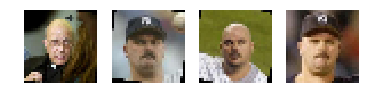

In [9]:
def visualize(img_arr):
    #plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0)) * 255.0).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i+22][0])
plt.show()

In [10]:
##Define model
disc = Discriminator(param)
gen = Decoder(param)

#parameter initialize
disc.collect_params().initialize(mx.init.Normal(0.02),ctx=ctx)
gen.collect_params().initialize(mx.init.Normal(0.02),ctx=ctx)

##loss 설정
- WGAN에서 사용한 방법을 적용
- 일종의 autoencoder를 통해 산출된 결과와 input data와의 Wassersterian distance의 lower bound를 loss로 정의

In [11]:
def disc_loss(outputs_d_x,data,outputs_d_z,gen_z):
    real_loss_d = F.mean(F.abs(outputs_d_x - data))
    fake_loss_d = F.mean(F.abs(outputs_d_z - gen_z))
    return (real_loss_d,fake_loss_d)

In [12]:
def gen_loss(outputs_g_z,gen_z):
    loss = F.mean(F.abs(outputs_g_z - gen_z))
    return loss

In [13]:
##Define optimizer
lr_scheduler = SimpleLRScheduler(learning_rate=0.0001)
train_gen = gluon.Trainer(gen.collect_params(),optimizer='Adam',optimizer_params={'lr_scheduler':lr_scheduler,'beta1':0.5,'beta2':0.999})
train_disc = gluon.Trainer(disc.collect_params(),optimizer='Adam',optimizer_params={'lr_scheduler':lr_scheduler,'beta1':0.5,'beta2':0.999})

In [14]:
iter_loss = dict()
iter_loss['lossD'] =[]
iter_loss['lossG'] =[]
iter_loss['k'] =[]
iter_loss['conv_measure'] =[]

## Bound Equilibrium 적용
\begin{align}
L_D = L(x) - k_tL(G(z_d)) ~~~~ for ~~\theta_D  \\
L_G = L(G(z_G)) ~~~~ for ~~\theta_D  \\
k_t+1 = k_t + \lambda_k(\gamma L(x) - L(G(z_G))) ~~~~ for~each~training~step~t
\end{align}

In [15]:
iter = 0
for epoch in range(1000):
    train_data.reset()
    for batch in train_data:
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.uniform(-1, 1, shape=(param['batch_size'],param['latent_z_size'] ), ctx=ctx)
        
        ##Discriminator loss
        #print("dis_loss")
        with autograd.record():
            gen_z = gen(latent_z)
            outputs_d_z = disc(gen_z.detach())
            outputs_d_x = disc(data)
            real_loss_d, fake_loss_d = disc_loss(outputs_d_x, data, outputs_d_z, gen_z)
            lossD = real_loss_d - param['k'] * fake_loss_d
            lossD.backward()
        train_disc.step(param['batch_size'])
        
        ##Generative loss
        with autograd.record():
            gen_z = gen(latent_z)
            outputs_g_z = disc(gen_z)
            lossG = gen_loss(outputs_g_z,gen_z)
            lossG.backward()
        train_gen.step(param['batch_size'])
        
        ##adjust learning rate
        if iter % 3000 == 0:
            lr_scheduler.learning_rate = lr_scheduler.learning_rate * (0.95**(iter//3000))
        
        balance = param['gamma']*real_loss_d.asscalar() - fake_loss_d.asscalar()

        param['k'] = param['k']  + param['lambda_k'] * balance

        conv_measure = real_loss_d.asscalar() + np.abs(balance)
        if iter % 100 == 0:
            iter_loss['lossD'].append(nd.mean(lossD).asscalar())
            iter_loss['lossG'].append(nd.mean(lossG).asscalar())
            iter_loss['conv_measure'].append(conv_measure)
        if iter % 200 == 0:
            print('discriminator loss = %f, generator loss = %f, conv_measurec = %f at iteration %d' %(iter_loss['lossD'][-1],iter_loss['lossG'][-1], iter_loss['conv_measure'][-1], iter))
        if iter % 5000 == 0:
            model_prefix = os.getcwd()+'/model/gen_model_iter_' + str(iter)
            gen.save_params(model_prefix)
        iter = iter +1

discriminator loss = 0.381832, generator loss = 0.000267, conv_measurec = 0.572719 at iteration 0
discriminator loss = 0.141072, generator loss = 0.044411, conv_measurec = 0.176953 at iteration 200
discriminator loss = 0.132325, generator loss = 0.057234, conv_measurec = 0.153947 at iteration 400
discriminator loss = 0.139001, generator loss = 0.044392, conv_measurec = 0.166635 at iteration 600
discriminator loss = 0.104097, generator loss = 0.035613, conv_measurec = 0.119056 at iteration 800
discriminator loss = 0.102891, generator loss = 0.032194, conv_measurec = 0.114535 at iteration 1000
discriminator loss = 0.133288, generator loss = 0.055198, conv_measurec = 0.162105 at iteration 1200
discriminator loss = 0.103090, generator loss = 0.046646, conv_measurec = 0.117260 at iteration 1400
discriminator loss = 0.095714, generator loss = 0.032125, conv_measurec = 0.111793 at iteration 1600
discriminator loss = 0.084585, generator loss = 0.030847, conv_measurec = 0.089213 at iteration 18

discriminator loss = 0.053416, generator loss = 0.025761, conv_measurec = 0.056029 at iteration 16200
discriminator loss = 0.050792, generator loss = 0.028091, conv_measurec = 0.054357 at iteration 16400
discriminator loss = 0.052174, generator loss = 0.027766, conv_measurec = 0.056752 at iteration 16600
discriminator loss = 0.043699, generator loss = 0.025169, conv_measurec = 0.047132 at iteration 16800
discriminator loss = 0.047943, generator loss = 0.029749, conv_measurec = 0.053736 at iteration 17000
discriminator loss = 0.047143, generator loss = 0.032998, conv_measurec = 0.056810 at iteration 17200
discriminator loss = 0.052575, generator loss = 0.027001, conv_measurec = 0.055939 at iteration 17400
discriminator loss = 0.053060, generator loss = 0.026617, conv_measurec = 0.055611 at iteration 17600
discriminator loss = 0.049284, generator loss = 0.028026, conv_measurec = 0.051349 at iteration 17800
discriminator loss = 0.056336, generator loss = 0.028291, conv_measurec = 0.060578

discriminator loss = 0.044688, generator loss = 0.023996, conv_measurec = 0.047260 at iteration 32400
discriminator loss = 0.048870, generator loss = 0.026539, conv_measurec = 0.051635 at iteration 32600
discriminator loss = 0.043601, generator loss = 0.026493, conv_measurec = 0.048832 at iteration 32800
discriminator loss = 0.052452, generator loss = 0.024101, conv_measurec = 0.056075 at iteration 33000
discriminator loss = 0.041176, generator loss = 0.025323, conv_measurec = 0.046406 at iteration 33200
discriminator loss = 0.040681, generator loss = 0.025490, conv_measurec = 0.046015 at iteration 33400
discriminator loss = 0.047689, generator loss = 0.025386, conv_measurec = 0.049649 at iteration 33600
discriminator loss = 0.047269, generator loss = 0.025586, conv_measurec = 0.049453 at iteration 33800
discriminator loss = 0.044775, generator loss = 0.024189, conv_measurec = 0.046980 at iteration 34000
discriminator loss = 0.043483, generator loss = 0.023920, conv_measurec = 0.046529

discriminator loss = 0.043568, generator loss = 0.024270, conv_measurec = 0.046376 at iteration 48600
discriminator loss = 0.049521, generator loss = 0.024510, conv_measurec = 0.050745 at iteration 48800
discriminator loss = 0.048581, generator loss = 0.023779, conv_measurec = 0.050031 at iteration 49000
discriminator loss = 0.046275, generator loss = 0.023466, conv_measurec = 0.046910 at iteration 49200
discriminator loss = 0.041334, generator loss = 0.025234, conv_measurec = 0.046226 at iteration 49400
discriminator loss = 0.045752, generator loss = 0.024135, conv_measurec = 0.047315 at iteration 49600
discriminator loss = 0.048612, generator loss = 0.024638, conv_measurec = 0.049251 at iteration 49800
discriminator loss = 0.043502, generator loss = 0.023400, conv_measurec = 0.045454 at iteration 50000
discriminator loss = 0.040827, generator loss = 0.024714, conv_measurec = 0.045445 at iteration 50200
discriminator loss = 0.048521, generator loss = 0.024640, conv_measurec = 0.049203

discriminator loss = 0.046186, generator loss = 0.023047, conv_measurec = 0.046677 at iteration 64800
discriminator loss = 0.048184, generator loss = 0.024515, conv_measurec = 0.048762 at iteration 65000
discriminator loss = 0.052906, generator loss = 0.024797, conv_measurec = 0.055029 at iteration 65200
discriminator loss = 0.047768, generator loss = 0.024708, conv_measurec = 0.048745 at iteration 65400
discriminator loss = 0.050709, generator loss = 0.023503, conv_measurec = 0.052996 at iteration 65600
discriminator loss = 0.046169, generator loss = 0.025010, conv_measurec = 0.048247 at iteration 65800
discriminator loss = 0.047107, generator loss = 0.024338, conv_measurec = 0.048037 at iteration 66000
discriminator loss = 0.048198, generator loss = 0.024298, conv_measurec = 0.048542 at iteration 66200
discriminator loss = 0.049350, generator loss = 0.024329, conv_measurec = 0.050126 at iteration 66400
discriminator loss = 0.054045, generator loss = 0.023994, conv_measurec = 0.057492

discriminator loss = 0.046035, generator loss = 0.024922, conv_measurec = 0.047965 at iteration 81000
discriminator loss = 0.046660, generator loss = 0.025227, conv_measurec = 0.048581 at iteration 81200
discriminator loss = 0.049950, generator loss = 0.023918, conv_measurec = 0.051071 at iteration 81400
discriminator loss = 0.046206, generator loss = 0.025668, conv_measurec = 0.048792 at iteration 81600
discriminator loss = 0.049508, generator loss = 0.024355, conv_measurec = 0.049961 at iteration 81800
discriminator loss = 0.048567, generator loss = 0.024815, conv_measurec = 0.049116 at iteration 82000
discriminator loss = 0.056801, generator loss = 0.024608, conv_measurec = 0.060640 at iteration 82200
discriminator loss = 0.045145, generator loss = 0.023939, conv_measurec = 0.046524 at iteration 82400
discriminator loss = 0.044936, generator loss = 0.024224, conv_measurec = 0.046704 at iteration 82600
discriminator loss = 0.047252, generator loss = 0.024650, conv_measurec = 0.048287

discriminator loss = 0.041979, generator loss = 0.023451, conv_measurec = 0.044336 at iteration 97200
discriminator loss = 0.050183, generator loss = 0.024478, conv_measurec = 0.050462 at iteration 97400
discriminator loss = 0.053344, generator loss = 0.025110, conv_measurec = 0.054560 at iteration 97600
discriminator loss = 0.049966, generator loss = 0.023557, conv_measurec = 0.051063 at iteration 97800
discriminator loss = 0.046822, generator loss = 0.025291, conv_measurec = 0.048584 at iteration 98000
discriminator loss = 0.047256, generator loss = 0.024373, conv_measurec = 0.047884 at iteration 98200
discriminator loss = 0.050527, generator loss = 0.024356, conv_measurec = 0.051079 at iteration 98400
discriminator loss = 0.047859, generator loss = 0.024381, conv_measurec = 0.048190 at iteration 98600
discriminator loss = 0.046602, generator loss = 0.023772, conv_measurec = 0.046955 at iteration 98800
discriminator loss = 0.047633, generator loss = 0.024515, conv_measurec = 0.048208

discriminator loss = 0.046281, generator loss = 0.024567, conv_measurec = 0.047465 at iteration 113200
discriminator loss = 0.047545, generator loss = 0.024444, conv_measurec = 0.047973 at iteration 113400
discriminator loss = 0.043393, generator loss = 0.025256, conv_measurec = 0.046700 at iteration 113600
discriminator loss = 0.042399, generator loss = 0.025117, conv_measurec = 0.046063 at iteration 113800
discriminator loss = 0.046530, generator loss = 0.025434, conv_measurec = 0.048440 at iteration 114000
discriminator loss = 0.044840, generator loss = 0.023509, conv_measurec = 0.045689 at iteration 114200
discriminator loss = 0.052279, generator loss = 0.024020, conv_measurec = 0.053658 at iteration 114400
discriminator loss = 0.041205, generator loss = 0.023839, conv_measurec = 0.044195 at iteration 114600
discriminator loss = 0.049221, generator loss = 0.024579, conv_measurec = 0.048933 at iteration 114800
discriminator loss = 0.043479, generator loss = 0.024110, conv_measurec =

discriminator loss = 0.049307, generator loss = 0.025567, conv_measurec = 0.049829 at iteration 129200
discriminator loss = 0.044766, generator loss = 0.024413, conv_measurec = 0.046421 at iteration 129400
discriminator loss = 0.039373, generator loss = 0.023844, conv_measurec = 0.043163 at iteration 129600
discriminator loss = 0.049021, generator loss = 0.024589, conv_measurec = 0.048718 at iteration 129800
discriminator loss = 0.045321, generator loss = 0.023013, conv_measurec = 0.045315 at iteration 130000
discriminator loss = 0.046883, generator loss = 0.024214, conv_measurec = 0.047278 at iteration 130200
discriminator loss = 0.047285, generator loss = 0.024613, conv_measurec = 0.047869 at iteration 130400
discriminator loss = 0.053262, generator loss = 0.024293, conv_measurec = 0.054450 at iteration 130600
discriminator loss = 0.048720, generator loss = 0.023477, conv_measurec = 0.048488 at iteration 130800
discriminator loss = 0.043576, generator loss = 0.023922, conv_measurec =

KeyboardInterrupt: 

In [27]:
model_prefix = os.getcwd()+'/began_perform_' + str(iter)
gen.save_params(model_prefix)

In [28]:
os.getcwd()

'/home/skinet/work/gluon_code'

In [16]:
num_image = 12

In [29]:
gen2 =  Decoder(param)
gen2.load_params('began_perform_' + str(iter),ctx=ctx)

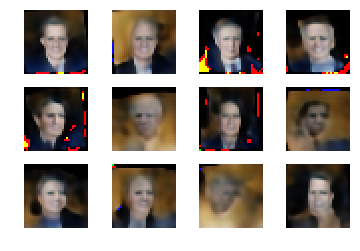

In [30]:
for i in range(num_image):
    latent_z = mx.nd.uniform(-1, 1, shape=(param['batch_size'],param['latent_z_size'] ), ctx=ctx)
    img = gen2(latent_z)
    #img = gen(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[3])
plt.show()